In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Response和Signaling的散点图

In [2]:
signature = 'Polarization'
sample = 'AML_GSE154109'
celltype_in_column = 'Mono/Macro'
celltype_in_file = 'Mono_Macro'

signaling_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/2.Signaling/{sample}.csv'
signaling_data = pd.read_csv(signaling_path, delimiter='\t', index_col=0, header=0)
celltype_list = [v.split('.')[0] for v in signaling_data.columns]
filter_flag = [v for v in signaling_data.columns if v.split('.')[0] == celltype_in_column]
signaling_data = signaling_data[filter_flag]

response_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/3-2.Polarization/{sample}.csv'
response_data = pd.read_csv(response_path, delimiter='\t', index_col=0, header=0)

signaling_data.shape, response_data.shape

((51, 2722), (5, 2722))

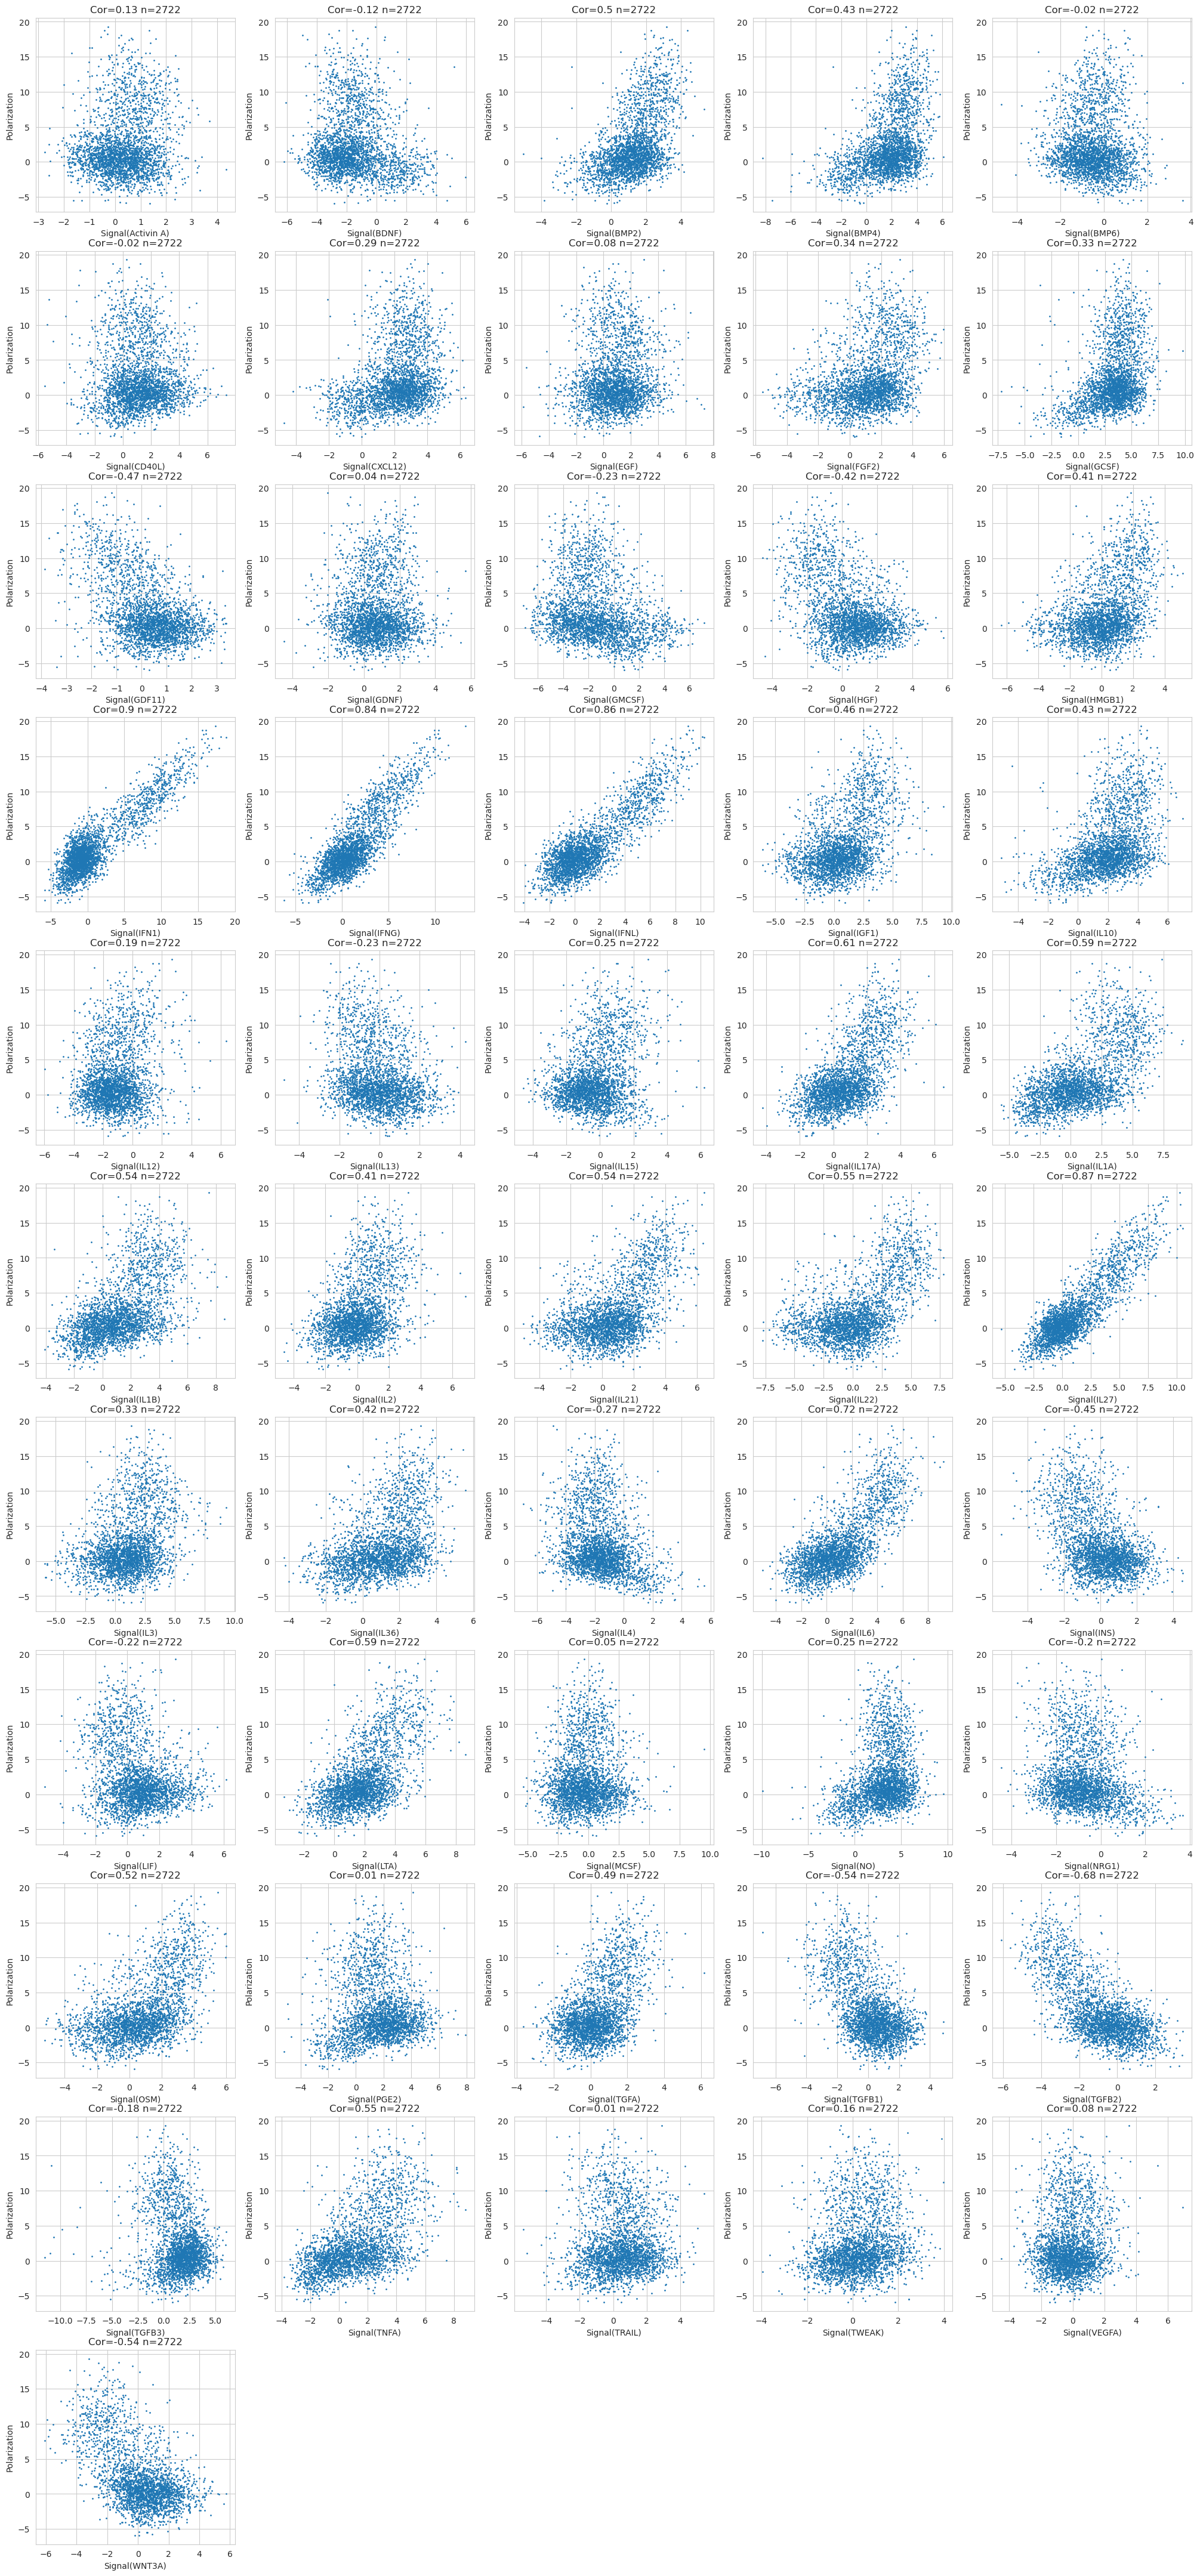

In [3]:
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr

fig = plt.figure(figsize=(25, 55))
ncols, nrows = 5, 11
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, width_ratios=[1] * ncols, height_ratios=[1] * nrows)

y = response_data.loc[signature]
i = 0
for cytokine in list(signaling_data.index):
    col = i % 5
    row = int(i / 5)
    ax = fig.add_subplot(gs[row, col])

    x = signaling_data.loc[cytokine]
    correlation, _ = pearsonr(x, y)
    
    ax.scatter(x, y, s=1)
    ax.set_xlabel(f'Signal({cytokine})')
    ax.set_ylabel(signature)
    ax.set_title(f'Cor={round(correlation, 2)} n={len(x)}')
    i += 1
plt.show()

## Response和Signaling相关性系数总结

/tmp/ipykernel_2027/3802564101.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  histplot.set_yticklabels(histplot.get_yticks(), size = 15)


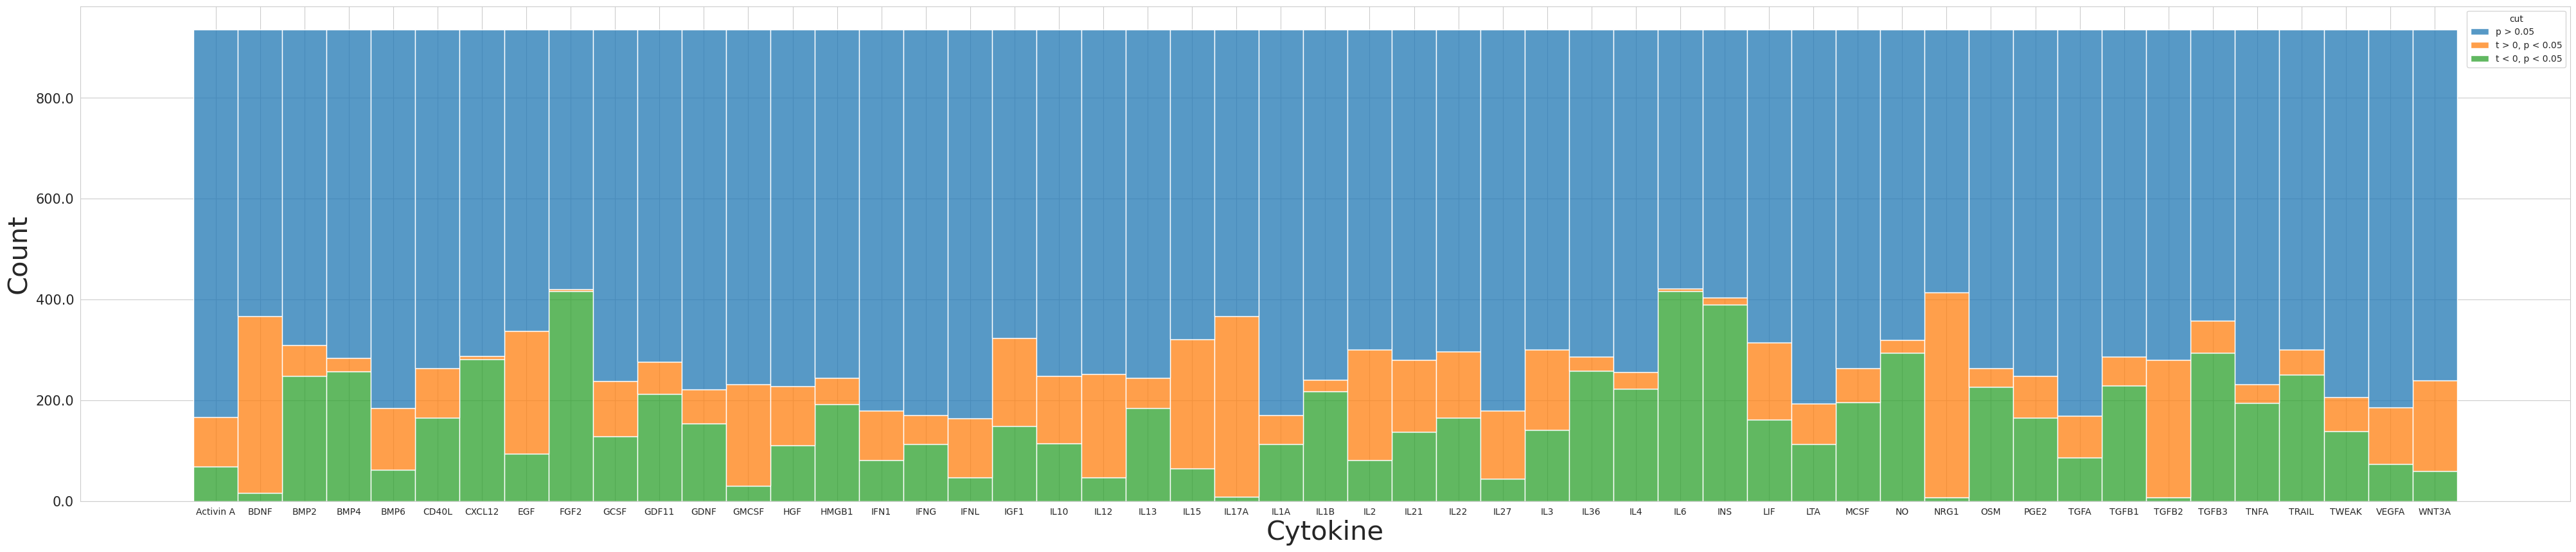

In [40]:
celltype = 'CD8T'
qc_result_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/qc_result.{celltype}.csv'
qc_result_data = pd.read_csv(qc_result_path, sep="\t", header=0)

def get_group(x):
    if x.t >= 0 and x.p <= 0.05:
        return "t > 0, p < 0.05"
    elif x.t <= 0 and x.p <= 0.05:
        return "t < 0, p < 0.05"
    elif x.p > 0.05:
        return "p > 0.05"
qc_result_data['cut'] = qc_result_data.apply(lambda x: get_group(x), axis=1)

fig = plt.figure(figsize=(50, 10))
histplot = sns.histplot(data=qc_result_data, x="Cytokine", hue="cut", multiple="stack", color='blue')
histplot.xaxis.label.set_size(30)
histplot.yaxis.label.set_size(30)
histplot.set_yticklabels(histplot.get_yticks(), size = 15)
plt.show()

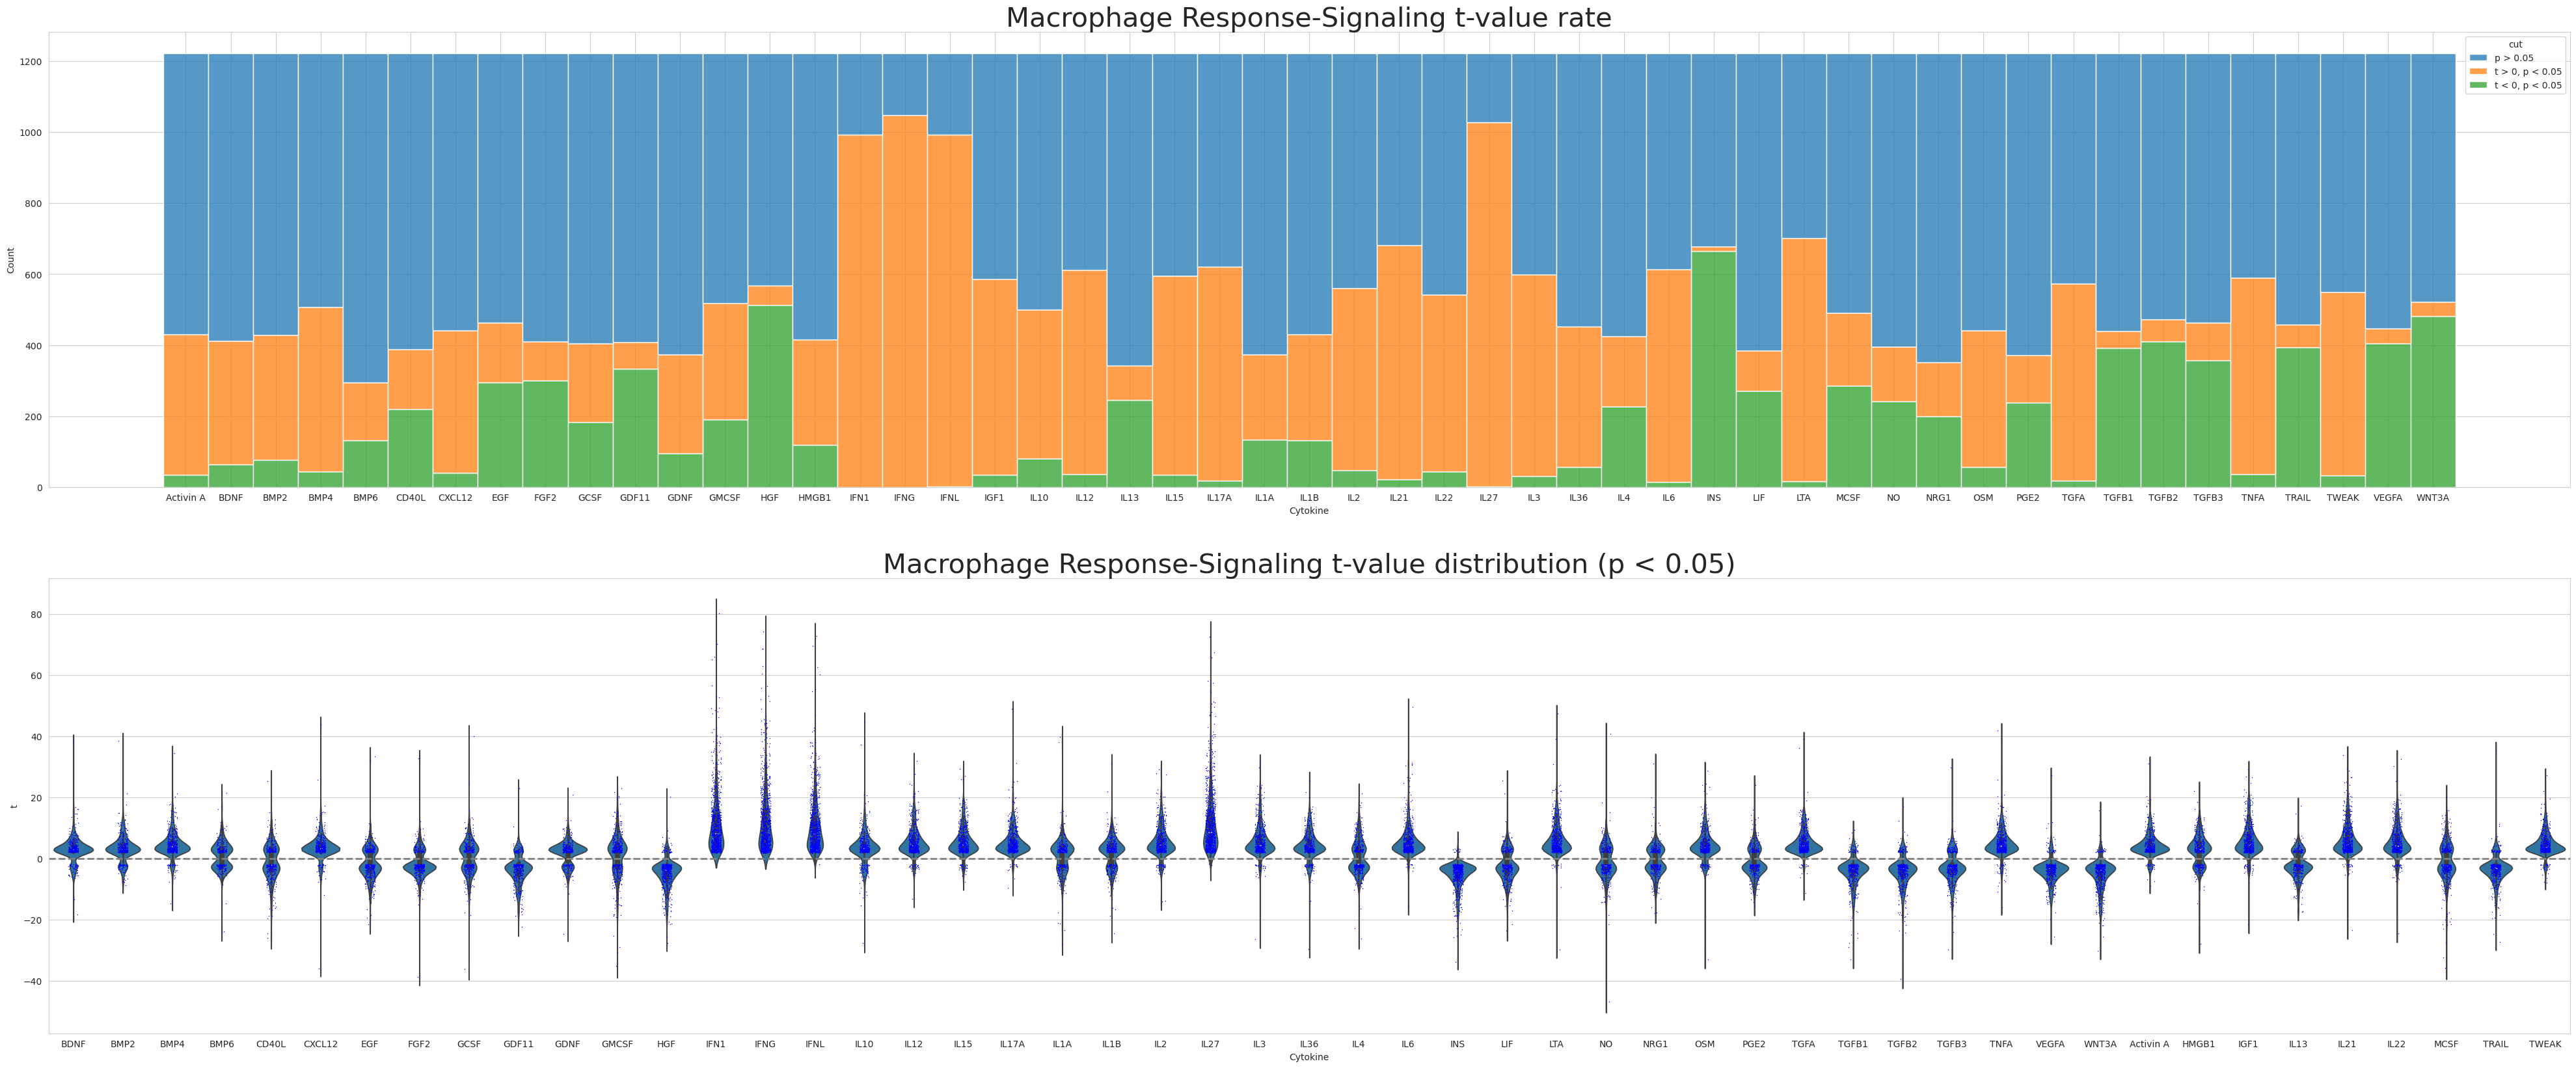

In [26]:
celltype = 'Macrophage'
qc_result_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/qc_result.{celltype}.csv'
qc_result_data = pd.read_csv(qc_result_path, sep="\t", header=0)

fig, axes = plt.subplots(2, 1, figsize=(50, 20))

sns.histplot(data=qc_result_data, x="Cytokine", hue="cut", multiple="stack", color='blue', ax=axes[0])
axes[0].set_title(f"{celltype} Response-Signaling t-value rate", size=30)

qc_result_data_filtered = qc_result_data[qc_result_data['p'] <= 0.05]
sns.violinplot(x="Cytokine", y="t", data=qc_result_data_filtered, ax=axes[1])
sns.stripplot(x="Cytokine", y="t", data=qc_result_data_filtered, color='b', size=1, ax=axes[1])
axes[1].axhline(0, color='grey', linestyle='--', linewidth=2)
axes[1].set_title(f"{celltype} Response-Signaling t-value distribution (p < 0.05)", size=30)
plt.show()

## Cytokine相关性小于0占比排序

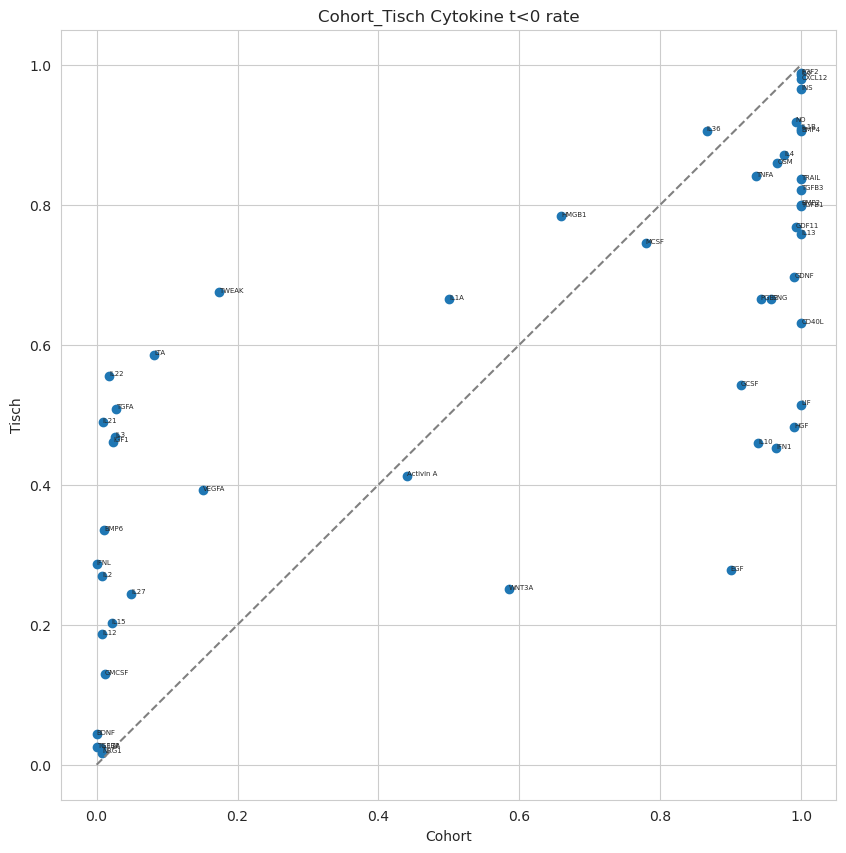

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy

celltype = 'CD8T'
qc_result_path1 = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/1.paper_data/3.qc_result/qc_result.CD8T.csv'
qc_result_path2 = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/qc_result.CD8T.csv'
qc_result_data1 = pd.read_csv(qc_result_path1, sep="\t", header=0)
qc_result_data2 = pd.read_csv(qc_result_path2, sep="\t", header=0)

def get_group(x):
    if x.t >= 0 and x.p <= 0.05:
        return 0
    elif x.t <= 0 and x.p <= 0.05:
        return 1
    elif x.p > 0.05:
        return -1

qc_result_data1['cut'] = qc_result_data1.apply(lambda x: get_group(x), axis=1)
qc_result_data2['cut'] = qc_result_data2.apply(lambda x: get_group(x), axis=1)
qc_result_filtered1 = qc_result_data1[qc_result_data1['cut'] >= 0]
qc_result_filtered2 = qc_result_data2[qc_result_data2['cut'] >= 0]

qc_result_groupby_Cytokine1 = qc_result_filtered1.groupby('Cytokine')
qc_result_groupby_Cytokine2 = qc_result_filtered2.groupby('Cytokine')

cut_mean1 = qc_result_groupby_Cytokine1['cut'].mean()
cut_mean2 = qc_result_groupby_Cytokine2['cut'].mean()

X = cut_mean1.values
Y = cut_mean2.values
label = cut_mean1.index

# save the t<0 rate rank
rank_table = pd.DataFrame(index=label, columns=['Cohort_rank', 'Tisch_rank', 'average'])
Cohort_rank = scipy.stats.rankdata(X, method='min')
Tisch_rank = scipy.stats.rankdata(Y, method='min')
average = (Cohort_rank + Tisch_rank) / 2
rank_table['Cohort_rank'] = Cohort_rank
rank_table['Tisch_rank'] = Tisch_rank
rank_table['average'] = average
rank_table_sort = rank_table.sort_values(by='average')
rank_table_sort.to_csv(f"/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/Rank.{celltype}.csv")

fig = plt.figure(figsize=(10, 10))
plt.scatter(X, Y)
for i in range(len(X)):
    plt.annotate(label[i], xy = (X[i], Y[i]), xytext = (X[i], Y[i]), fontsize = 5)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('Cohort_Tisch Cytokine t<0 rate')
plt.xlabel('Cohort')
plt.ylabel('Tisch')
plt.show()

In [38]:
celltype = 'Macrophage'
qc_result_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/qc_result.{celltype}.csv'
qc_result_data = pd.read_csv(qc_result_path, sep="\t", header=0)

def get_group(x):
    if x.t >= 0 and x.p <= 0.05:
        return 0
    elif x.t <= 0 and x.p <= 0.05:
        return 1
    elif x.p > 0.05:
        return -1

qc_result_data['negative_rate'] = qc_result_data.apply(lambda x: get_group(x), axis=1)
qc_result_filtered = qc_result_data[qc_result_data['negative_rate'] >= 0]
negative_rate = qc_result_filtered.groupby('Cytokine')['negative_rate'].mean()
negative_rate.sort_values(ascending=False, inplace=True)
negative_rate.to_csv(f"/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/Rank.{celltype}.csv")
negative_rate

Cytokine
INS          0.982275
WNT3A        0.921456
VEGFA        0.908072
HGF          0.904762
TGFB1        0.888636
TGFB2        0.868644
TRAIL        0.859956
GDF11        0.816626
TGFB3        0.769397
FGF2         0.734146
IL13         0.716374
LIF          0.705729
PGE2         0.638814
EGF          0.635776
NO           0.610127
MCSF         0.583673
NRG1         0.566952
CD40L        0.564433
IL4          0.533019
GCSF         0.450495
BMP6         0.445578
GMCSF        0.366795
IL1A         0.355615
IL1B         0.304651
HMGB1        0.286058
GDNF         0.251337
BMP2         0.177156
IL10         0.162000
BDNF         0.152913
OSM          0.126697
IL36         0.125828
CXCL12       0.090703
IL2          0.085561
BMP4         0.084813
IL22         0.081181
Activin A    0.079070
TNFA         0.062818
IGF1         0.059727
IL12         0.058824
TWEAK        0.058182
IL15         0.057047
IL3          0.051839
IL21         0.032305
TGFA         0.029668
IL17A        0.027375
L